# Chemical Process Anomaly Detection Baseline 🕵️
### 화학 공정 데이터를 분석하고 🧐, 이상 탐지 Baseline Model 을 학습합니다 📖.


## Table of Contents
1. 필요 Library Import
2. Load Data
3. EDA
4. K-means Clustering
5. Inference

### 1. 필요 Library Import

- 필요 Library 설치를 위해 아래 명령어를 실행 합니다.
- (실행 초기에 한 번만 실행하면 됩니다!)

In [1]:
# ! pip install -r requirements.txt

- 노트북에서 사용하는 필요 Library 를 import 합니다

In [37]:
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path

# plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

# model
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# scaling
from sklearn.preprocessing import StandardScaler

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

- 모델 학습에 필요한 `random_seed` 를 설정하고, `DATA_PATH` 를 설정합니다.
- 해당 `DATA_PATH` 에는 `train.csv`, `test.csv` 파일이 있다고 가정합니다.

In [38]:
RANDOM_SEED = 42
DATA_PATH = Path("../data")

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


### 2. Load Train Data


In [39]:
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")
sample_submission = pd.read_csv(DATA_PATH / "sample_submission.csv")

### 3. EDA

### 3.1 데이터 유형 확인

- 학습 데이터는 총 2500000 개의 row 와 55개의 column을 갖고 있습니다.

In [40]:
train_data.shape

(250000, 55)

각 column의 의미는 다음과 같습니다.
- `faultNumber` : 정상인지, 비정상인지 나타내는 Label 입니다. 정상일 경우 `0`, 비정상일 경우 `1` 입니다. 
- `simulationRun` : 시뮬레이션이 실행된 Run 의 번호 입니다. 
  - 동일한 하나의 `simulationRun` 이 정상일 경우 `faultNumber` 가 모두 `0` 입니다.
  - 반대로 하나의 `simulationRun` 이 비정상일 경우 `faultNumber` 가 모두 `1` 입니다.
  - 학습 데이터에는 정상 데이터만 존재합니다. 따라서 `faultNumber` 가 모두 `0` 입니다.
  - 테스트 데이터에는 정상/비정상 데이터가 모두 존재합니다. 따라서 `faultNumber` 가 모두 `0`인 `simulationRun` 도 있고, `faultNumber` 모두 `1`인 `simulationRun` 도 있습니다.
- `sample` : 하나의 Run 안의 sample 번호를 의미합니다. 학습 데이터는 한 Run 당 500 sample 이 있습니다.
- `xmeas_*` : measurement 의 약자로, 화학 공정에서 측정된 센서 값 입니다.
- `xmv_*` : manipulated variable 의 약자로, 화학 공정에서 제어되는 값 입니다.
    - measurement 와 manipulated 관련 설명은 [다음 자료](https://chemicalada.blogspot.com/2016/02/classification-of-variables-in-chemical.html)를 참고하시기 바랍니다.
    

In [41]:
train_data.describe()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,250000.0,250000.000000,250000.000000,250000.000000,250000.000000,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.0,250.500000,250.500000,0.250482,3663.785706,4508.81979,9.347101,26.902196,42.337598,2705.037865,...,53.973668,24.639472,61.298501,22.216644,40.055456,38.098898,46.534295,47.958591,41.104304,18.118706
std,0.0,144.337567,144.337567,0.030873,34.006357,39.21542,0.085721,0.211485,0.218513,7.525596,...,0.469663,3.037743,1.243805,0.530156,1.526751,2.965266,2.351304,2.716520,0.540817,1.463678
min,0.0,1.000000,1.000000,0.122450,3511.800000,4336.90000,8.972700,25.951000,41.394000,2672.300000,...,52.095000,11.977000,55.961000,19.749000,33.389000,25.959000,36.937000,36.641000,38.586000,11.705000
25%,0.0,125.750000,125.750000,0.229770,3640.800000,4482.40000,9.289300,26.758000,42.188000,2700.100000,...,53.657000,22.602000,60.453000,21.864000,39.021000,36.081000,44.931000,46.265000,40.740000,17.130000
50%,0.0,250.500000,250.500000,0.250510,3663.700000,4508.80000,9.347100,26.902000,42.338000,2705.000000,...,53.974000,24.644000,61.298000,22.217000,40.058000,38.091000,46.530000,47.820000,41.104000,18.119000
75%,0.0,375.250000,375.250000,0.271200,3686.800000,4535.30000,9.405100,27.046000,42.487000,2710.000000,...,54.290000,26.674000,62.144000,22.568000,41.084000,40.117000,48.140000,49.651000,41.470000,19.111000
max,0.0,500.000000,500.000000,0.391740,3808.400000,4683.70000,9.729800,27.818000,43.257000,2739.100000,...,56.118000,38.351000,66.443000,24.525000,47.498000,50.729000,56.443000,59.616000,43.930000,24.762000


학습 데이터에 대해 Histogram 을 그려보면, 다음을 알 수 있습니다.
  - `faultNumber` 값은 `0` 인 정상 데이터 만 존재합니다.
  - `simulationRun`, `sample` 값은 `0` ~ `500` 까지 일정하게 빈도수가 분포되어 있습니다.
  - `xmeas_*`, `xmv_*` 값의 범위는 다 다르고, 정규 분포와 비슷하게 데이터가 분포되어있습니다.

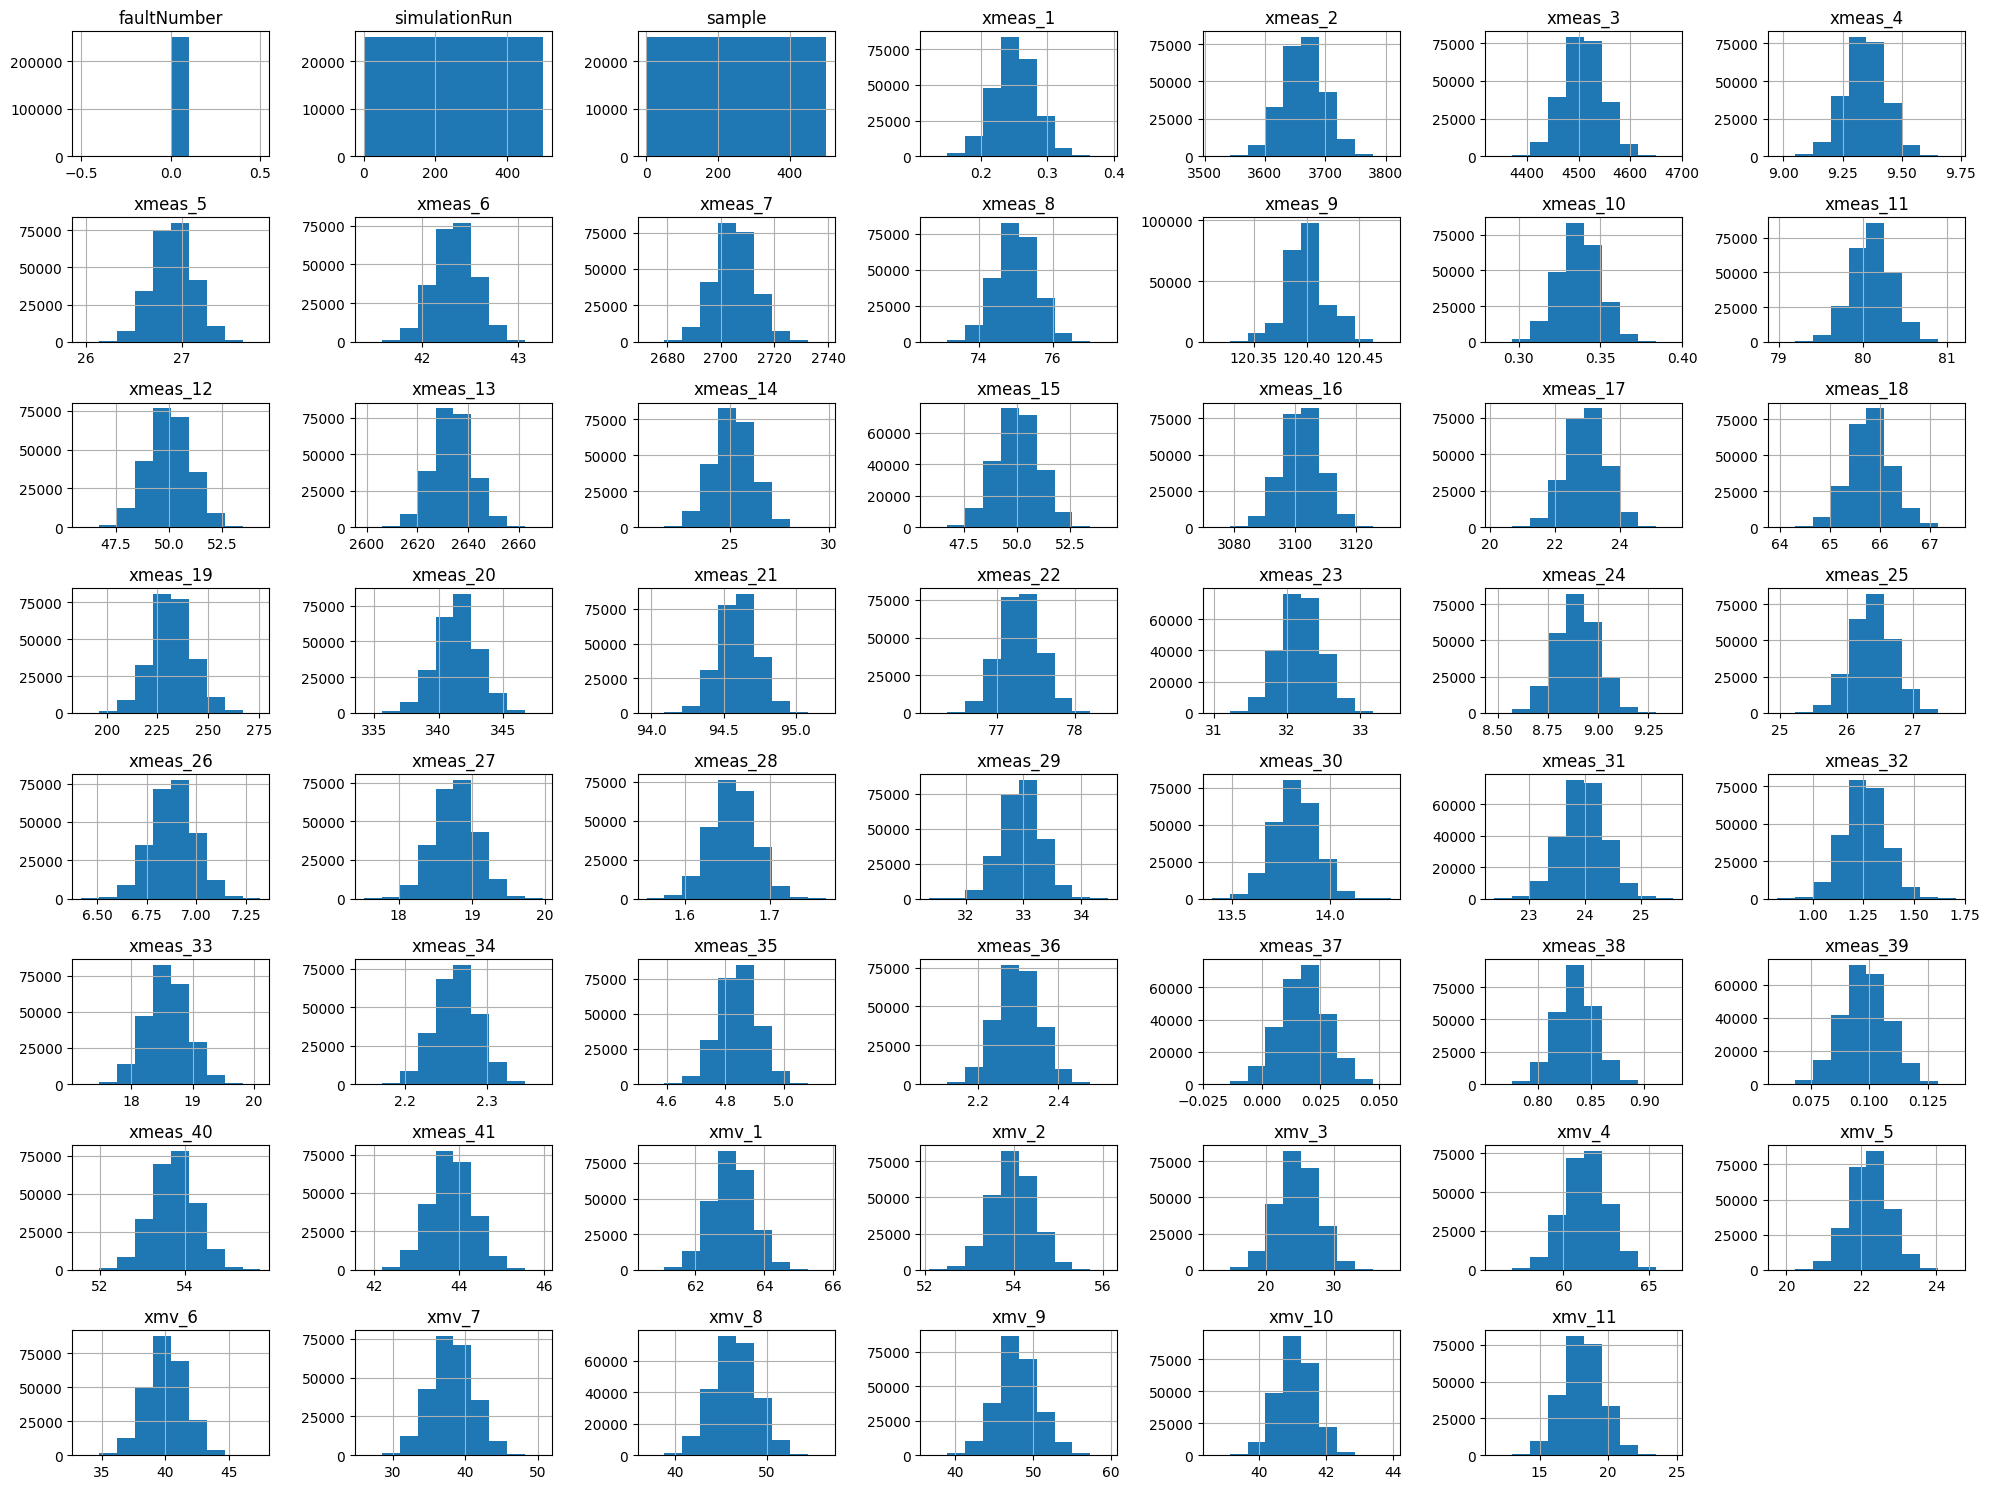

In [42]:
train_data.hist(figsize=(20, 15))
plt.tight_layout()
plt.show()

### 3.2 데이터 시각화

아래에는 데이터를 시각화를 위해 `plotly` 라는 패키지를 사용합니다.
기본적으로 `requirements.txt` 에 포함되어 있으나, 설치하지 않은 분들은 아래 명령어를 실행해주시기 바랍니다.

In [43]:
# ! pip install plotly

`simulationRun` 의 데이터 양상을 확인하기 위해, 처음 `5000` row 를 그려보면 `500` row 마다 `1` 증가하는 것을 확인할 수 있습니다 

In [44]:
fig = px.line(train_data[["simulationRun"]].iloc[:5000], title='simulationRun Plot')
fig.update_layout(plot_bgcolor='#ffffff')
fig.show()

`simulationRun` 를 `sample` 데이터와 같이 그려보면, 동일한 `simulationRun` 값에 대해 `1`부터 `500`까지 증가한 후, `simulationRun` 이 증가하는 시점에 다시 `1` 로 초기화 됨을 알 수 있습니다.

In [45]:
from plotly.subplots import make_subplots

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig1 = px.line(train_data[["simulationRun"]].iloc[:5000])
fig2 = px.line(train_data[["sample"]].iloc[:5000])
fig2.update_traces(yaxis="y2")

subfig.layout.yaxis.title="index"
subfig.layout.yaxis.title="simulationRun"
subfig.layout.yaxis2.title="sample"
subfig.layout.title = "simulationRun and sample plot" 
subfig.add_traces(fig1.data + fig2.data)
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.update_layout(plot_bgcolor='#ffffff')
subfig.show()

위에서 확인한 것 처럼, 1개의 `simulationRun` 은 `500` 개의 `sample` 로 이루어져 있으므로, 임의의 `simulationRun==1` 값에 대해 `xmeas`, `xmv` 값을 시각화 합니다.

In [46]:
from plotly.subplots import make_subplots

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig1 = px.line(train_data.query("simulationRun == 1")[["xmeas_1"]])
fig2 = px.line(train_data.query("simulationRun == 1")[["xmv_1"]])
fig2.update_traces(yaxis="y2")

subfig.layout.yaxis.title="index"
subfig.layout.yaxis.title="xmeas_1"
subfig.layout.yaxis2.title="xmv_1"
subfig.layout.title = "xmeas_1 and xmv_1 plot for simulationRun == 1" 
subfig.add_traces(fig1.data + fig2.data)
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.update_layout(plot_bgcolor='#ffffff')
subfig.show()

### 3.2 Plot Correlation matrix

- 센서 값(`xmeas`, `xmv`) 들의 변수간 상관 관계를 이해하기 위해, Corrleation Matrix 를 시각화 합니다.
- Correlation 의 값이 0(초록색)에 가까울 수록, 변수간 상관 관계가 적다는 것을 뜻합니다.
- 반대로, Correlation 의 값이 1(노란색) 또는 -1(남색) 에 가까울 수록, 양 또는 음의 상관 관계가 강하게 나타남을 의미합니다.
- 일부 변수들 끼리 양, 음의 상관 관계가 강하게 나타남을 알 수 있습니다.

In [47]:
import pandas as pd
import plotly.graph_objects as go

# 학습 데이터의 상관관계를 계산합니다.
correlation_matrix = train_data.corr()

# Plotly 를 이용하여 Heatmap 을 그립니다.
fig = go.Figure(
    data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.index,
        colorscale='Viridis',
        text=correlation_matrix.round(2),  # 상관관계를 소수점 2자리 까지 표시합니다.
        hoverinfo='text',
    )
)
fig.update_layout(
    title='Correlation Matrix',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    width=800, height=800,
    plot_bgcolor='#ffffff'
)
fig.show()

### 3.3 Plot pairs with high/low correlations
- correlation matrix 값 중, 상관 관계 절대 값이 높은 조합의 변수들을 찾아 구체적으로 시각화해보겠습니다.
- 이 때, correlation matrix 의 다음 항목들은 제외합니다.
  - upper triangle 값과 lower triangle 값은 동일하므로, lower triangle 은 제외합니다.
  - 자기 자신과의 상관관계는 1이므로, diagonal 영역의 값은 제외합니다.

In [48]:
# correlation matrix 의 diagonal 을 제외한 upper triangle 값을 추출합니다.
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# (NxN) -> (N^2 X 1) 로 변환(stack) 후, pandas dataframe 을 만듭니다. 
correlation_df = upper_triangle.stack().reset_index().rename(columns={0: "correlation_value"})

- 내림 차순으로 상관관계를 정렬하여 양의 상관 관계가 높은 변수 쌍은 다음과 같습니다.

In [49]:
top_5_correlations = correlation_df.sort_values(by="correlation_value", ascending=False)[:5]
print(top_5_correlations)

      level_0   level_1  correlation_value
646  xmeas_12     xmv_7           1.000000
761  xmeas_15     xmv_8           1.000000
401   xmeas_7  xmeas_13           0.997386
147   xmeas_1     xmv_3           0.996587
900  xmeas_19     xmv_9           0.986063


In [50]:
def plot_pairs(data1:pd.DataFrame, data2:pd.DataFrame, correlation_value:float):
    subfig = make_subplots(specs=[[{"secondary_y": True}]])

    fig1 = px.line(data1)
    fig2 = px.line(data2)
    fig2.update_traces(yaxis="y2")
    
    name1 = data1.columns.item()
    name2 = data2.columns.item()
    subfig.layout.yaxis.title="index"
    subfig.layout.yaxis.title= name1
    subfig.layout.yaxis2.title= name2
    subfig.layout.title = f"{name1} and {name2} plot (Correlation : {correlation_value:.4f})" 
    subfig.add_traces(fig1.data + fig2.data)
    subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
    subfig.update_layout(plot_bgcolor='#ffffff')
    subfig.show()

- `simulationRun == 1` 인 데이터에 대해 시각화한 결과, 상관 관계가 높은 데이터가 다수 존재함을 알 수 있습니다.
  - `xmeas_12` 와 `xmv_7` 처럼 상관 관계가 `1` 인 데이터는 scale 차이는 있으나, 증/감 패턴이 완전하게 동일합니다.
  - `xmeas_19` 와 `xmv_9` 처럼 상관 관계가 `1` 에 가까운 데이터도 또한 데이터 증/감 패턴이 매우 유사합니다.

In [51]:
plot_data = train_data.query("simulationRun == 1")
for _, row in top_5_correlations.iterrows():
    plot_pairs(plot_data[[row["level_0"]]], plot_data[[row["level_1"]]], correlation_value = row["correlation_value"])

- 오름 차순으로 상관관계를 정렬하여 음의 상관 관계가 높은 변수 쌍은 다음과 같습니다.

In [52]:
bottom_5_correlations = correlation_df.sort_values(by="correlation_value")[:5]
print(bottom_5_correlations)

      level_0   level_1  correlation_value
835  xmeas_17    xmv_11          -0.999243
920  xmeas_20  xmeas_38          -0.581375
399   xmeas_7  xmeas_11          -0.576832
571  xmeas_11  xmeas_13          -0.565694
670  xmeas_13  xmeas_33          -0.565231


- 동일한 데이터에 대해 시각화한 결과, 상관 관계가 낮은 데이터가 일부 존재함을 알 수 있습니다.
  - `xmeas_17` 와 `xmv_11` 처럼 상관 관계가 `-1` 에 가까운 데이터는 데이터끼리 증/감 패턴이 반대로 나타나는 것을 알 수 있습니다.
  - `xmeas_20` 와 `xmeas_38` 처럼 상관 관계가 `-0.5814` 인 데이터는 증/감 패턴이 반대로 나타나는 양상이 일부분 보이는 것을 알 수 있습니다.

In [53]:
for _, row in bottom_5_correlations.iterrows():
    plot_pairs(plot_data[[row["level_0"]]], plot_data[[row["level_1"]]], correlation_value = row["correlation_value"])

### 고민해볼 사항 🤔
- 일반적인 ML Model 에서 상관관계가 거의 1인 변수들의 경우, 중복된 정보량을 담고 있으므로 학습에 제거하는 경우가 있습니다.
- 하지만 학습 데이터인 **정상 데이터 대해 상관 관계를 계산** 한 것이고, 비정상 데이터에선 동일 데이터의 상관관계가 달라질 수 있습니다.
- 실제 화학 공정에서 이상이 발생하는 경우는 특정 변수들과의 상관 관계가 깨지는 경우도 포함될 수 있습니다.
- 따라서, 상관 관계에 따라 변수를 선택할지 제거할지 결정할 땐 **모델의 성능**과 같이 고려하는 것이 바람직합니다.

### 4. K-means Clustering

다음은 K-means clustering에서 적용 해야 할 순서이다.

- n_estimators 정하기
- 집단별 centroid 좌표 찾아내기
- 최종적으로 test 데이터 적합하여 결과 가져오기

추가적인 과정으로 다음과 같은 과정을 진행한다.

> Scaling  
> PCA

#### 4-0. 필요 없는 변수는 제외하고 적합하기

measure, maniplate 변수만을 활용하여 적합해보기 위해 필요한 변수만 가져오는 과정을 진행한다.

- `simulationRun` 과 `sample` 변수는 큰 정보량을 담고 있지 않기 때문에, 공정의 센서 값을 반영하는 변수들을 선택합니다.
- 따라서, `process_data` 함수에서는 `xmeas`, `xmv` 와 같은 숫자형 변수들을(numerical value) 초도 모델 학습에 사용합니다.
- 정규화와 feature engineering의 과정은 포함되지 않았으므로, `process_data` 함수 전, 후로 더 다양한 전처리 과정을 추가해보시길 권장합니다.

---------------------------------------------------------------------------------------------------------------------------------  
- 처음 적합했던 결과에서 유의미했던 변수만 가지고 다시한번 적합

In [54]:
def process_data(df) -> pd.DataFrame:
    numeric_cols = [
        'xmeas_1', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
        'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_2',
        'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
        'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_3', 'xmeas_30',
        'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
        'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_4', 'xmeas_40', 'xmeas_41',
        'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmv_1',
        'xmv_10', 'xmv_11', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6',
        'xmv_7', 'xmv_8', 'xmv_9'
    ]
    return df[numeric_cols]

In [55]:
train_X = process_data(train_data)
test_X = process_data(test_data)

데이터의 거리가 각자 차이가 나는 단위가 다를 수 있기 때문에 표준화를 진행하도록 한다.

In [56]:
# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   
scaler.fit(train_X)
train_X_scaler = pd.DataFrame(scaler.transform(train_X), columns = train_X.columns)
test_X_scaler = pd.DataFrame(scaler.transform(test_X), columns = train_X.columns)

유의미한 변수만을 활용하기 위해 PCA를 도입하기로 함

- 앞선 다른 실험에서 PCA가 3, 4차원일 경우 성적이 가장 좋았다는 결론을 받았기 때문에 현재 실험은 3차원으로 진행

In [57]:
#PCA 3차원 축소
pca3 = PCA(n_components=3, random_state=42)
pca3.fit(train_X_scaler)
pca3_result = pca3.transform(train_X_scaler)

In [58]:
# 변수 넣어주기
train_X_scaler[['PCA_3_x', 'PCA_3_y', 'PCA_3_z']] = pca3_result

In [59]:
# test에도 적용 해주기
pca3_test = pca3.transform(test_X_scaler)

In [60]:
# # 변수 반영해주기
test_X_scaler[['PCA_3_x', 'PCA_3_y', 'PCA_3_z']] = pca3_test

#### 4-1. Elbow Method

팔꿈치 처럼 굽히는 부분을 선택한다 해서 Elbow Method라 부른다. 최적의 Centroid의 개수를 구하기 위해서 사용하는 방법이다.

In [22]:
# Inertia 값을 저장할 리스트 초기화
inertia = []

# 1부터 10까지의 k 값에 대해 KMeans 클러스터링 수행 및 inertia 계산
for k in range(1, 11):
    ad_kmeans = KMeans(
        n_clusters=k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42,
        algorithm = 'full'
    ).fit(train_X_scaler)       # 데이터 적용

    # 각 k에 대한 Inertia 값 계산 및 추가
    inertia.append(ad_kmeans.inertia_)

# Inertia 값 출력
print(inertia)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed 

[12999999.999999985, 11754575.29192625, 11289857.698020458, 10935713.733834855, 10760776.919081116, 10593685.299415713, 10445981.642096553, 10351884.158577833, 10263338.304703332, 10190994.30255115]


In [23]:
# Inertia 값과 클러스터 수 k를 DataFrame으로 변환
df_inertia = pd.DataFrame(dict(
    k = [x for x in range(1, 11)],  # 클러스터 수 k (1부터 10까지)
    inertia = inertia,  # 각 k에 대한 Inertia 값
))

# Inertia 값에 대한 꺾은 선 그래프 생성
fig_inertia = px.line(
    df_inertia,
    x = "k",         # x축은 클러스터 수 k
    y = "inertia"    # y축은 Inertia 값
)

# 배경색은 하얀색
fig_inertia.update_layout(plot_bgcolor='#ffffff')

# 그래프 표시
fig_inertia.show()

현재 그림상에서 k = 2 부터 k = 4 구간이 가장 잘 구부러져 있는 형상을 보이고 있다.
또다른 클러스터링 선택 방법인 실루엣 방법을 적용해보려 한다.

#### 4-2. 실루엣 방법

실루엣 계수는 다음과 같이 계산된다.

> 1. 데이터 포인트 i와 같은 클러스터 내의 모든 데이터 포인트 간의 거리의 평균을 a(i)로 계산합니다.  
> 2. 데이터 포인트 i와 가장 가까운 클러스터의 모든 데이터 포인트 간의 거리의 평균을 b(i)로 계산합니다.  
> 3. 데이터 포인트 i의 실루엣 계수 s(i)는 (b(i) - a(i)) / max(a(i), b(i))로 계산됩니다.  

출처: [Tstory](https://gsbang.tistory.com/entry/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5-k-means-%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81-%EC%B5%9C%EC%A0%81%EC%9D%98-k%EA%B0%92-%ED%83%90%EC%83%89)

[선택 방법]
- 실루엣 계수가 가장 높은 값을 가지는 값을 선택한다.  
- 그러나 산 모양처럼 높이 솟아 오른 부분을 선택하기도 한다.

[목적]
- 팔꿈치 방법의 그래프가 너무 애매하기 때문에 실루엣 방법을 통해 다시한번 확인해 보고자 한다.

[추가적인 자료]
- [Velog](https://velog.io/@rsj9987/TIL-21.05.27-K-means-cluster%EC%9D%98-K%EA%B0%92-%EA%B5%AC%ED%95%98%EA%B8%B0)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed 

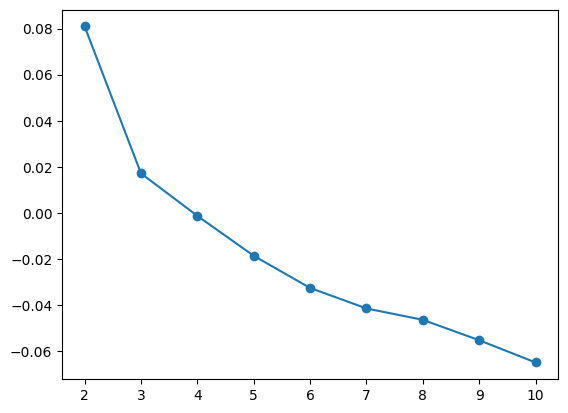

In [24]:
# 실루엣 분석을 사용하여 최적의 K값 탐색
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42,
        algorithm = 'full')
    kmeans.fit(train_X_scaler)
    score = silhouette_score(train_X, kmeans.labels_)
    silhouette_scores.append(score)

# 실루엣 분석 그래프 그리기
plt.plot(range(2, 11), silhouette_scores, marker='o')

> Elbow : k = 2 ~ 4  
> Silluate : k = 2

두 결과를 종합한 결과 k = 2 로 세팅하는것이 가장 무난하다. 따라서 먼저 train을 통해 모델 적합을 진행한다.

#### 4-3. Best k means clustering

다음과 같은 순서로 경계선을 만듬

> 1. k-means clustering을 통해 centroid 지점을 찾는다.
> 2. 유클리드 거리를 활용해 train의 최대 거리 지점을 구한다.

이로써 train을 통해 정상 범위의 데이터를 판단할 수 있는 최대 거리를 찾을 수 있다.

In [61]:
# parameters
best_k = 2 # centroid의 best 개수 -> elbow, 실루엣 두 방법을 비교하여 선정한다.
abnormal = 1 # 시뮬레이션에서 이상치 판독 기준 개수

In [62]:
# Best k 적합하기
best = KMeans(
        n_clusters = best_k,    # 클러스터 수 설정
        init="random",   # 초기 중심점을 무작위로 선택
        n_init="auto",    # k-means 알고리즘 반복 실행 횟수 설정
        random_state=42,
        algorithm = 'full'
    ).fit(train_X_scaler)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning:

algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.



In [63]:
# 유클리드 거리
def distance(p1, p2):
    # p1, p2 -> numpy array
    # 유클리디언 거리 계산: 두 점 사이의 각 차원의 차이를 제곱한 후, 이들의 합의 제곱근을 반환
    return np.sqrt(np.sum((p1 - p2) ** 2))

In [64]:
# 각 데이터 포인트와 해당 클러스터 중심점 간의 거리 계산
tmp = train_X_scaler - best.cluster_centers_[best.labels_]
tmp = tmp ** 2
tmp['dist'] = tmp.apply(sum, axis = 1)
distance_to_centroid = np.array(tmp['dist'] ** 0.5)

In [65]:
# 각 클러스터에 대한 최대값 계산
maximum_distance_for_centroid = [np.quantile(distance_to_centroid[best.labels_ == i], 1) for i in range(best.n_clusters)]

### 5. Inference

- 모델의 이상치를 k-means clustering으로 추론합니다.

방식은 다음과 같습니다.

> 1. test data와 centroid의 거리를 구합니다.
> 2. 사전에 구했던 train의 정상 최대 거리보다 커지는 경우 이상치로 판단합니다.
> 3. 현재 Baseline에서 1개만 이상치가 존재하면 SimulationRun이 동일한 번호를 모두 이상치로 판단합니다.

추가적으로 다음과 같은 요인을 변경하여 method를 추가 보완할 수 있습니다.

> - 이상치의 개수를 1개가 아닌 a개가 이상치일 때 그 SimulationRun이 이상치라 판단할 수 있다.
> - 거리의 계산 방법이 유클리드가 아닌 다른 방법을 활용해 적용한다.

In [66]:
# 유클리드 거리로 centroid 계산하기
for i, center in enumerate(best.cluster_centers_):
    tmp2 = test_X_scaler - best.cluster_centers_[i]
    tmp2 = tmp2 ** 2
    tmp2['dist'] = tmp2.apply(sum, axis = 1)
    test_data[f'cent{i}'] = tmp2['dist'] ** 0.5

In [67]:
# 거리가 더 작은 값의 centroid를 선택하여 계산한 거리와 centroid 넘버를 가져옴
test_data['min_d_centroid'] = np.argmin(test_data[[col for col in test_data.columns if col.startswith('cent')]], axis = 1)
test_data['min_d'] = np.min(test_data[[col for col in test_data.columns if col.startswith('cent')]], axis = 1)

# 각 centroid에 맞는 최대의 distance를 가져오기
test_data['max_normal'] = test_data['min_d_centroid'].apply(lambda x: maximum_distance_for_centroid[x])

# 최대 거리와 비교해서 더 크면 이상치, 같거나 작으면 정상치로 두기
test_data['anomaly'] = np.where(test_data['min_d'] <= test_data['max_normal'], 0, 1)

- SimulationRun을 기준으로 숫자를 맞춰줘야 한다. 따라서 값의 조절을 진행한 다음 결과를 생성하도록 한다.

In [68]:
# 각 simulationRun을 맞추기 위해 이상치의 합산을 구한다.
sum_anomaly = test_data.groupby('simulationRun').sum().reset_index()[['simulationRun', 'anomaly']]

# 개수의 합이 abnormal보다 크면 1, 아니면 0
sum_anomaly['last_label'] = np.where(sum_anomaly['anomaly'] >= abnormal, 1, 0)

# abnormal에 맞춰 최종 label 생성
test_data2 = pd.merge(test_data, sum_anomaly, how = 'left', on = 'simulationRun')

In [69]:
# 최종적으로 값 넣어주기
sample_submission['faultNumber'] = test_data2['last_label']

Test set이 어떻게 분리되었는가를 확인해 보기 위해 시각화를 하기로 한다.

In [70]:
# 분석에 사용된 변수와 이상치 판별만 남김
test_X_scaler['anomaly'] = test_data['anomaly']
df = test_X_scaler

In [71]:
# line plot으로 이상치와 정상치의 평균의 차이를 확인하기 위한 plot
df2 = df.groupby('anomaly').mean() # 그룹별 평균
df3 = df2.T.reset_index() # 인덱스 초기화
df3.columns = ['name', 'normal', 'anomaly'] # 이름 재설정
df3['diff'] = abs(df3['anomaly'] - df3['normal']) # 차이의 절댓값

In [72]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df3['name'], y=df3['diff'], name='difference',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Bar(x=df3['name'], y=df3['normal'], name='normal', marker = {'color':'royalblue'}))

fig.add_trace(go.Bar(x=df3['name'], y=df3['anomaly'], name='anomaly', marker = {'color':'darkblue'}))

# Edit the layout
fig.update_layout(title='정상과 이상의 평균에 대한 차이',
                   xaxis_title='Variable',
                   yaxis_title='Means')

fig.show()

In [73]:
# 최종적으로 만드는 제출 저장하기
sample_submission.to_csv('../data/sample_submission_k-means_scaling_PCA_extend.csv', index = False)